# <span style="color:blue"> STEP 1: import libraries </span>

In [11]:
# import packages

# pyspark
import pyspark
sc = pyspark.SparkContext(appName='Project').getOrCreate()
from pyspark.sql.session import SparkSession
spark = SparkSession(sc)

# pyspark sql window funtions
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.window import Window

# basic packages
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors as mcolors

# linear regression
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# qqline plot
import scipy.stats as stats
from statsmodels.graphics.gofplots import ProbPlot

# warnings
import warnings
warnings.simplefilter(action='ignore')

# <span style="color:blue"> STEP 2: import the dataset

In [13]:
# read csv file
df = spark.read.options(header=True, sep=';', inferSchema="true").csv("project_data_real_estate_toulouse_and_suburbs.xls", multiLine=True)
df.show(5)

+----------+--------+------+--------+-------------------+-------+------+-------------+----------+--------+
|  SaleDate|SaleType| Price|PostCode|               City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|
+----------+--------+------+--------+-------------------+-------+------+-------------+----------+--------+
|15/01/2019|    SALE| 95000|   31270|VILLENEUVE TOLOSANE|      2|     0|        HOUSE|        45|     505|
|21/01/2019|    SALE|261700|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        87|     311|
|03/01/2019|    SALE|101000|   31270|VILLENEUVE TOLOSANE|      2|     1|    APARTMENT|        44|       0|
|11/01/2019|    SALE| 59500|   31270|VILLENEUVE TOLOSANE|      1|     1|    APARTMENT|        26|       0|
|15/01/2019|    SALE|179000|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        95|     263|
+----------+--------+------+--------+-------------------+-------+------+-------------+----------+--------+
only showing top 5 rows



In [14]:
# schema
df.printSchema()

root
 |-- SaleDate: string (nullable = true)
 |-- SaleType: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- PostCode: integer (nullable = true)
 |-- City: string (nullable = true)
 |-- NbRooms: integer (nullable = true)
 |-- NbLots: integer (nullable = true)
 |-- ResidenceType: string (nullable = true)
 |-- LivingArea: integer (nullable = true)
 |-- LandArea: integer (nullable = true)



In [16]:
# create dataframe 
df.createOrReplaceTempView('df')

# <span style="color:blue"> STEP 3: data enrichment </span>

We enrich some columns to make analytical process efficient:
1. year : year of saledate
2. month : month of saledate
3. year_month : year and momth of saledate
4. unitprice : price per square (price devided by livingarea)
5. log_unitprice : log(unitprice)

Considering we're going to build price prediction models, we convert some categorical values into boolean:
1. n_residencetype : apartment = 0 / house = 1
2. n_saletype : sale = 0 / sale before completion = 1


In [22]:
# check 08/04/2015
price_08042015 = spark.sql('select * from df where saledate = "08/04/2015" and price = "33427218"')
price_08042015.show(5)

+----------+--------+--------+--------+--------+-------+------+-------------+----------+--------+
|  SaleDate|SaleType|   Price|PostCode|    City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|
+----------+--------+--------+--------+--------+-------+------+-------------+----------+--------+
|08/04/2015|    SALE|33427218|   31500|TOULOUSE|      2|     0|    APARTMENT|        48|     188|
|08/04/2015|    SALE|33427218|   31500|TOULOUSE|      2|     0|    APARTMENT|        51|     188|
|08/04/2015|    SALE|33427218|   31500|TOULOUSE|      2|     0|    APARTMENT|        49|     188|
|08/04/2015|    SALE|33427218|   31500|TOULOUSE|      2|     0|    APARTMENT|        43|     188|
|08/04/2015|    SALE|33427218|   31500|TOULOUSE|      2|     0|    APARTMENT|        53|     188|
+----------+--------+--------+--------+--------+-------+------+-------------+----------+--------+
only showing top 5 rows



In [23]:
# enrich dataset

# convert price (string) into price(int)
df = df.withColumn("price",translate(col("price"),",",""))
df = df.withColumn("price", df.price.cast('float'))

# enrich dataset
df = df.withColumn('year', split(df['SaleDate'], '/').getItem(2))\
       .withColumn('month', split(df['SaleDate'],'/').getItem(1))\
       .withColumn('year_month', concat(col('year'), lit('-'), col('month')))

# compute unitprice
df = df.withColumn('unitprice', df['price']/df['LivingArea'])

# take log to unitprice to reduce the skewness
df = df.withColumn("log_unitprice", log(df["unitprice"]) )

# convert residencetype into 0 and 1
df = df.withColumn("n_residencetype", when(df.ResidenceType=="HOUSE", 1)
                   .when(df.ResidenceType=='APARTMENT',0)
                   .otherwise(df.ResidenceType))

df = df.withColumn("n_residencetype", df.n_residencetype.cast('int'))

# convert saletype into 0 and 1
df = df.withColumn("n_saletype", when(df.SaleType=='SALE',0)
                   .when(df.SaleType=='SALE BEFORE COMPLETION',1)
                   .otherwise(df.SaleType))

df = df.withColumn("n_saletype", df.n_saletype.cast('int'))

# convert postcode (int) into string
df = df.withColumn("PostCode", df.PostCode.cast('string'))

# add unique id in dataset
df = df.withColumn('id', monotonically_increasing_id())
df = df.withColumn("id", df.id.cast('string'))

df.show(5, truncate=False) # truncate=False :show all the content 

+----------+--------+--------+--------+-------------------+-------+------+-------------+----------+--------+----+-----+----------+------------------+-----------------+---------------+----------+---+
|SaleDate  |SaleType|price   |PostCode|City               |NbRooms|NbLots|ResidenceType|LivingArea|LandArea|year|month|year_month|unitprice         |log_unitprice    |n_residencetype|n_saletype|id |
+----------+--------+--------+--------+-------------------+-------+------+-------------+----------+--------+----+-----+----------+------------------+-----------------+---------------+----------+---+
|15/01/2019|SALE    |95000.0 |31270   |VILLENEUVE TOLOSANE|2      |0     |HOUSE        |45        |505     |2019|01   |2019-01   |2111.1111111111113|7.654969680812358|1              |0         |0  |
|21/01/2019|SALE    |261700.0|31270   |VILLENEUVE TOLOSANE|4      |0     |HOUSE        |87        |311     |2019|01   |2019-01   |3008.0459770114944|8.009045969863653|1              |0         |1  |
|03/0

In [24]:
df.printSchema()

root
 |-- SaleDate: string (nullable = true)
 |-- SaleType: string (nullable = true)
 |-- price: float (nullable = true)
 |-- PostCode: string (nullable = true)
 |-- City: string (nullable = true)
 |-- NbRooms: integer (nullable = true)
 |-- NbLots: integer (nullable = true)
 |-- ResidenceType: string (nullable = true)
 |-- LivingArea: integer (nullable = true)
 |-- LandArea: integer (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- year_month: string (nullable = true)
 |-- unitprice: double (nullable = true)
 |-- log_unitprice: double (nullable = true)
 |-- n_residencetype: integer (nullable = true)
 |-- n_saletype: integer (nullable = true)
 |-- id: string (nullable = false)



In [25]:
# save changes
df.createOrReplaceTempView('df')

# <span style="color:blue"> STEP 3: insigth1 - identify outliers </span>

1. 7 residences sold whose price is equal to 0 
2. 270 residences sold in the same price within a date (08/04/2015), which makes the sales increase sharply

In [29]:
# identify outliers

# price = 0 or = null
price_0 = spark.sql('select count(*) as count_price_0 from df where price = 0 or price is null')
price_0.show()

# remove price = 0 or = null
df = df.filter("price!='0'")

# save modificaitons 
df.createOrReplaceTempView('df')

+-------------+
|count_price_0|
+-------------+
|            0|
+-------------+



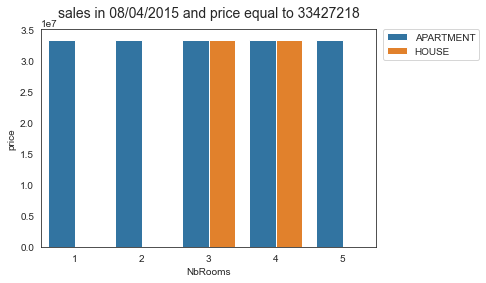

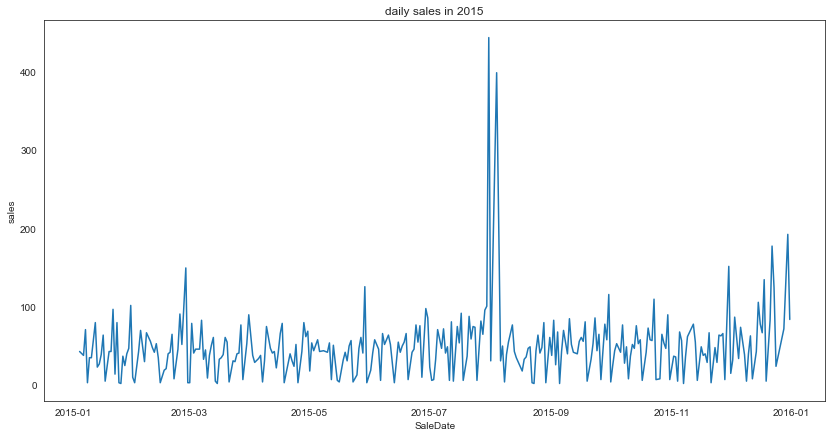

In [36]:
# check 08/04/2015 
price_08042015 = spark.sql('select * from df where saledate = "08/04/2015" and price="33427218"')
price_08042015.count()

# convert into pandas df
price_08042015_df = price_08042015.toPandas()

# data viz 
sales_bar = sns.barplot(data=price_08042015_df, x='NbRooms', y='price', hue='ResidenceType')
sales_bar.set_title('sales in 08/04/2015 and price equal to 33427218', fontdict={'fontsize':14}, pad=12)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()


#-------------------------------------------------------------------------------------------

# select needed data
residencetype = spark.sql('select residencetype, saledate, count(*) as count from df where year=2015 group by residencetype, saledate')

# convert into pandas df
residencetype_df = residencetype.toPandas()

# convert saledate into time data type
residencetype_df['saledate']= pd.to_datetime(residencetype_df['saledate'])

# data viz 
plt.figure(figsize = (14, 7))
chart = sns.lineplot(data=residencetype_df[residencetype_df.residencetype =="APARTMENT"], x='saledate', y='count')
chart.set_title('daily sales in 2015')
chart.set_xlabel('SaleDate')
chart.set_ylabel('sales')
plt.show()

# <span style="color:blue"> STEP 3: insigth2 - skewed unitprice distribution </span>

Based on the figure of unitprice distirbution, we find that the unitprice skewed in the left side so we decide to take log() to reduce the skewness before executing our basic analytics.

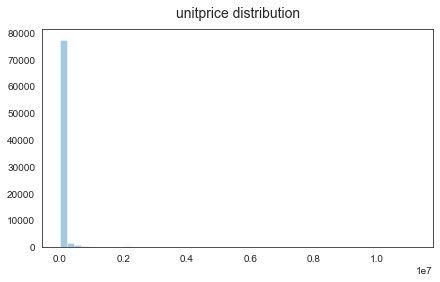

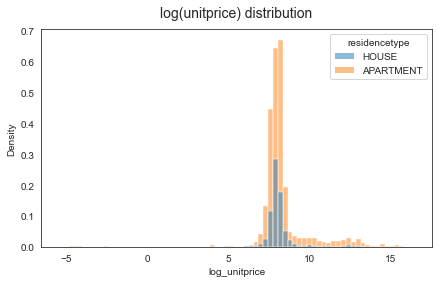

In [37]:
# unitprice distribution - residence type
unitprice = spark.sql('select unitprice from df')

# convert into pandas df
unitprice_df = unitprice.toPandas()

# data viz
sns.set_style("white")
plt.figure(figsize=(7,4))
dist_unitprice = sns.distplot(unitprice_df, kde=False)
dist_unitprice.set_title('unitprice distribution', fontdict={'fontsize':14}, pad=12)
plt.show()

# log_price distribution - residence type
price = spark.sql('select log_unitprice, residencetype from df ')

# convert into pandas df
price_df = price.toPandas()

# daya viz
plt.figure(figsize=(7,4))
hist_log = sns.histplot(data=price_df, x='log_unitprice', hue='residencetype', stat='density', binwidth=0.3)
hist_log.set_title('log(unitprice) distribution', fontdict={'fontsize':14}, pad=12)
plt.show()

# <span style="color:blue"> STEP 3: insigth3 - total sales per year <span>

The real estate market has generally more demands / needs during July and December. However, 2019 experience a huge slump in sales.

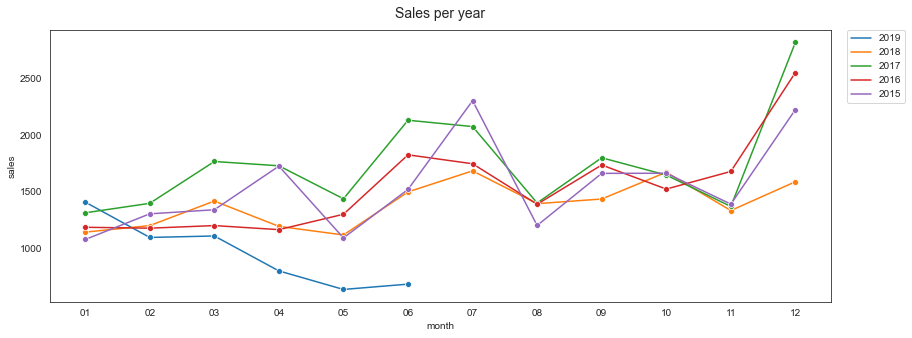

In [38]:
# sales per year
deal = spark.sql('select month, year, count(*) as sales from df group by year, month sort by month, year desc')

# convert into pandas df
deal_df = deal.toPandas()

# data viz 
plt.figure(figsize=(14,5))
deals_line = sns.lineplot(data=deal_df, x='month', y='sales', hue='year', marker='o')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
deals_line.set_title('Sales per year', fontdict={'fontsize':14}, pad=12)
plt.show()

# <span style="color:blue"> STEP 3: insigth4 - price evolution <span>
    
1. The price seems stable in the general look. 
2. In Toulouse city, the price is more unstable compared with suburbs, especially for months where have more demands / needs on the market. 
3. No matter in which city we buy the residence, house price is always more stable than apartment, which migh be a good choice for who wants to invest in real estate market without taking the high risk.

22/04/17 18:16:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/17 18:16:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/17 18:16:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/17 18:16:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


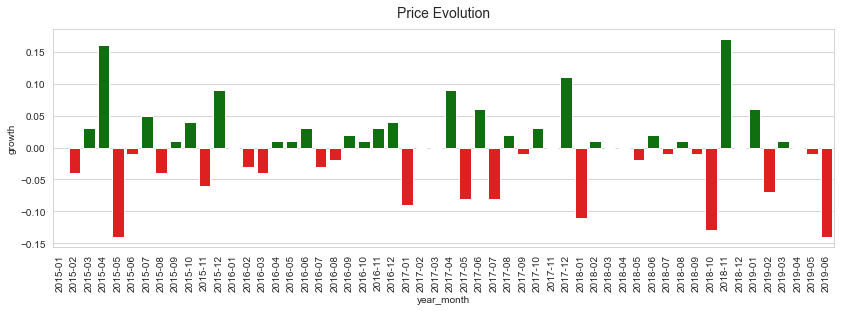

In [40]:
# price evolution -- general overview
window = Window.orderBy('year_month')

# price evolution (general overview)
overview = df.groupby('year_month')\
             .agg({'log_unitprice':'avg'})\
             .withColumnRenamed('avg(log_unitprice)','log(unitprice)')

overview = overview.withColumn("lastprice", lag(col("log(unitprice)"),1).over(window))\
                   .withColumn("pricediff", col("log(unitprice)") - col("lastprice"))\
                   .withColumn("growth", round(col('pricediff')/col('lastprice'),2))

# convert into pandas df
overview_df = overview.toPandas()

# add color based on growth rate
overview_df['Color'] = np.where(overview_df["growth"]<0, 'red', 'green')

# data viz
plt.figure(figsize=(14,4))
sns.set_style("whitegrid")
# plot
Toulouse_appart_bar = sns.barplot(data=overview_df, x='year_month', y='growth', ci=None, hue='Color', dodge=False, palette=['g','r'])
plt.xticks(rotation=90)                  # change x-axis angle
plt.legend('',frameon=False)             # close lengend
Toulouse_appart_bar.set_title('Price Evolution', fontdict={'fontsize':14}, pad=12)
plt.show()


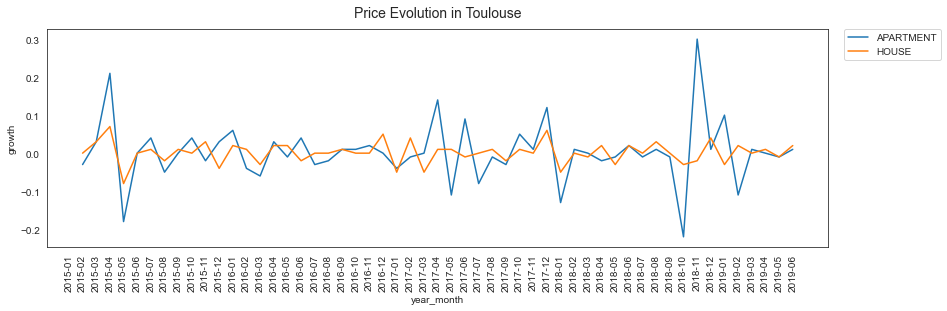

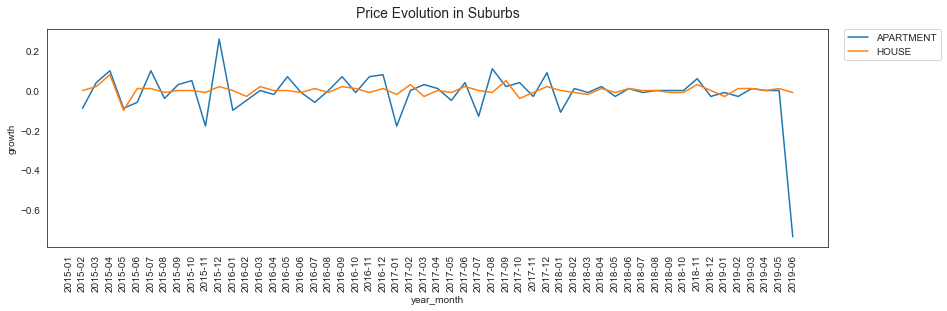

In [44]:
# stability of price
window2 = Window.partitionBy('ResidenceType').orderBy('year_month')

# stability of price for Toulouse's apartment / house

Toulouse = df.filter('City == "TOULOUSE"')\
             .groupby('year_month','ResidenceType')\
             .agg({'log_unitprice':'avg'})\
             .withColumnRenamed('avg(log_unitprice)','log(unitprice)')

Toulouse = Toulouse.withColumn("lastprice", lag(col("log(unitprice)"),1).over(window2))\
                   .withColumn("pricediff", col("log(unitprice)") - col("lastprice"))\
                   .withColumn("growth", round(col('pricediff')/col('lastprice'),2))

# convert into pandas df
Toulouse_df = Toulouse.toPandas()


# data viz
plt.figure(figsize=(14,4))
sns.set_style("white")
# plot
toulouse_line = sns.lineplot(data=Toulouse_df, x='year_month', y='growth', ci=None, hue='ResidenceType')
plt.xticks(rotation=90)                  # change x-axis angle
toulouse_line.set_title('Price Evolution in Toulouse', fontdict={'fontsize':14}, pad=12)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

#--------------------------------------------------------------------------------------------------------------
# stability of price for Toulouse suburbs's apartment / house
suburbs = df.filter('City != "TOULOUSE"')\
            .groupby('year_month','ResidenceType')\
            .agg({'log_unitprice':'avg'})\
            .withColumnRenamed('avg(log_unitprice)','log(unitprice)')

suburbs = suburbs.withColumn("lastprice", lag(col("log(unitprice)"),1).over(window2))\
                 .withColumn("pricediff", col("log(unitprice)") - col("lastprice"))\
                 .withColumn("growth", round(col('pricediff')/col('lastprice'),2))

# convert into pandas df
suburbs_df = suburbs.toPandas()

# data viz
plt.figure(figsize=(14,4))
sns.set_style("white")
# plot
suburbs_line = sns.lineplot(data=suburbs_df, x='year_month', y='growth', ci=None, hue='ResidenceType')
plt.xticks(rotation=90)                  # change x-axis angle         
suburbs_line.set_title('Price Evolution in Suburbs', fontdict={'fontsize':14}, pad=12)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

# <span style="color:blue"> STEP 3: insigth5 - porpotion of residence type per city <span>
    

1. There're has more demands / needs on apartements in Toulouse City, they occupied more than 80% of its residences sold. 
2. However, it's totally different situation in Vieille Toulouse, where the majority of the residence type is House instead of Apartement.

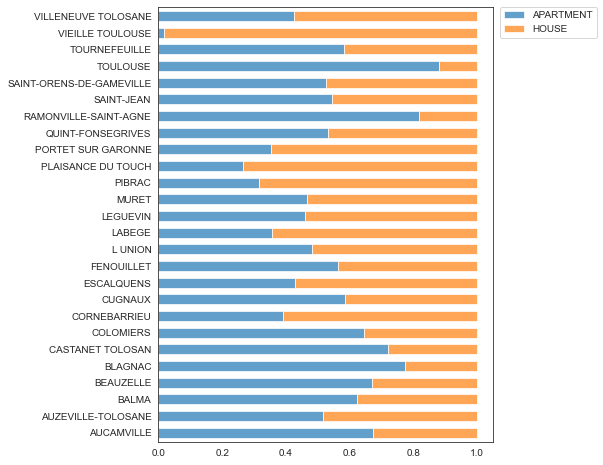

In [45]:
# number of HOUSE / APARTMENT - percentage for each city
num_residence_1 = spark.sql('select city, residencetype, count(*) as num from df group by city, residencetype sort by city')
num_residence_2 = spark.sql('select city as city2, count(*) as total from df group by city sort by city')
num_residence = num_residence_1.join(num_residence_2, num_residence_1.city==num_residence_2.city2, 'left')
num_residence = num_residence.withColumn('per', (num_residence.num/num_residence.total))\
                             .drop('city2','num','total')

# convert into pandas df
num_residence_df = num_residence.toPandas()

# convert into pivot table
num_residence_pivot = num_residence_df.pivot(index='city', columns='residencetype', values='per')

# data viz
num_residence_pivot.plot(stacked=True, kind='barh', alpha=0.7, width=0.6)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.gcf().set_size_inches(6,8)
plt.ylabel('') 
plt.show()

# <span style="color:blue">  Bonus point : price prediction model building <span>

We choose correlation heatmap to understand better the correlation between log_unitprice and each feature and to define which one should put into our prediction model. 

In the figure below, we can found:
1. Except from living area, number of rooms has the stronger correlation than others.
2. In fact, none of the features has the significant correlation with log_unitprice in this dataset, which might influence the accuracy of prediction model. 

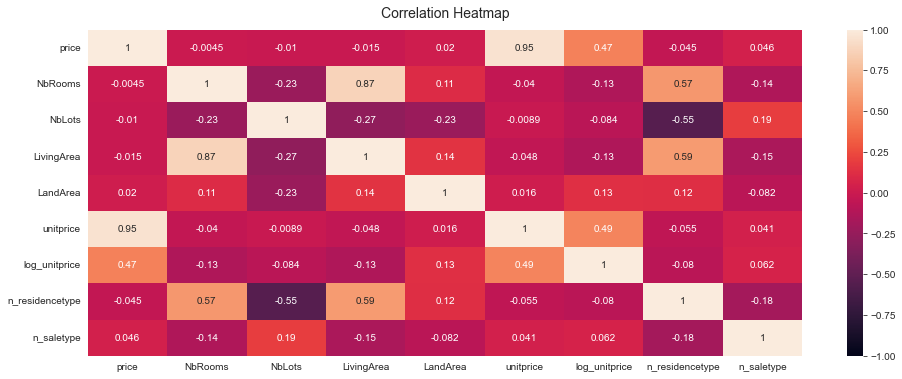

In [47]:
# convert whole dataset into pandas df
df_df = df.toPandas()

# data viz
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12)
plt.show()

# <span style="color:blue">  STEP 1: Remove Outliers <span>
    
To exclude outliers in our model, we use boxplot lower / upper whisker method to remove them.

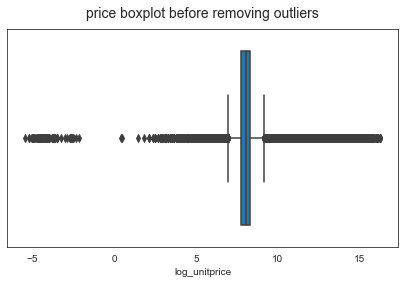

lower :  7.346329590844044
upper :  8.720830039539777
IQR : 0.2749000897391465


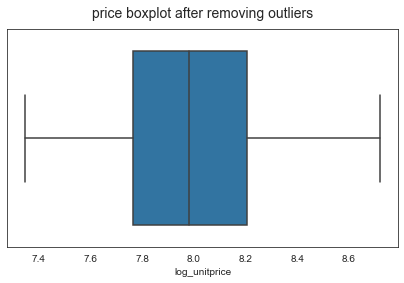

In [46]:
# log unitprice box plot
price_box = spark.sql('select log_unitprice from df')

# convert into price box
price_box_df = price_box.toPandas()

# data viz 
plt.figure(figsize=(7,4))
outliers_box = sns.boxplot(data=price_box_df, x='log_unitprice')
outliers_box.set_title('price boxplot before removing outliers', fontdict={'fontsize':14}, pad=12)
plt.show()

# remove the outliers
outliers = spark.sql('select log_unitprice from df')

# convert into pandas df
outliers_df = outliers.toPandas()

# find Q1 & Q3 & IQR
Q1 = np.quantile(outliers_df, .25)
Q3 = np.quantile(outliers_df, .75)
IQR = (np.quantile(outliers_df, .75)-np.quantile(outliers_df, .25))/2

# Q1-1.5IQR / Q3+1.5IQR
print("lower : ", Q1-1.5*IQR) 
print("upper : ", Q3+1.5*IQR) 
print("IQR :", IQR)


ml_data = spark.sql('select * from df where log_unitprice between 7.346329590844044 and 8.720830039539777')

# create dataset for prediction model
ml_data.createOrReplaceTempView('ml_data')

# check box plot 
ml_data_df = ml_data.toPandas()

plt.figure(figsize=(7,4))
outliers_box2 = sns.boxplot(data=ml_data_df, x='log_unitprice')
outliers_box2.set_title('price boxplot after removing outliers', fontdict={'fontsize':14}, pad=12)
plt.show()

# <span style="color:blue">  STEP 2: Model Building <span>
    
**Model Building porcess :**

1. Exclude "LivingArea" in our model because we use price devided by livingarea to get unitprice, which it's not independent feature. 
2. Convert city into numeric value by using StringIndexer()
3. Split the train and test dataset randomly (80:20)
4. Analyze residuals : residuals distirbution and qqline-plot

**Finding :**
1. After removing outliers, we got an dataset(df_lr) whose price only between a specific range, which might be one of the reason that we've the simliar R-squared and RMSE value for both training and testing data. 
2. After taking log(), our residuals distribution looks bell-curve, which seems normal distribution. Plus, we've a good fit in qqline-plot.

**limitations : hard to define which features should out into the models**
    
1. In the correlation heatmap, the majority of the features don't have the significant correlation with log_unitprice.
2. We tried to use PCA model to define which features should put into the model but we failed to get the dimensions result.

In [56]:
# select data needed
df_lr = spark.sql('select id, n_saletype, n_residencetype, city, nbrooms, nblots, landarea, log_unitprice from ml_data')
df_lr.show(5)

df_lr.cache()

+---+----------+---------------+-------------------+-------+------+--------+-----------------+
| id|n_saletype|n_residencetype|               city|nbrooms|nblots|landarea|    log_unitprice|
+---+----------+---------------+-------------------+-------+------+--------+-----------------+
|  0|         0|              1|VILLENEUVE TOLOSANE|      2|     0|     505|7.654969680812358|
|  1|         0|              1|VILLENEUVE TOLOSANE|      4|     0|     311|8.009045969863653|
|  2|         0|              0|VILLENEUVE TOLOSANE|      2|     1|       0|7.738686161905135|
|  3|         0|              0|VILLENEUVE TOLOSANE|      1|     1|       0|7.735635053512239|
|  4|         0|              1|VILLENEUVE TOLOSANE|      4|     0|     263|7.541264193222351|
+---+----------+---------------+-------------------+-------+------+--------+-----------------+
only showing top 5 rows



DataFrame[id: string, n_saletype: int, n_residencetype: int, city: string, nbrooms: int, nblots: int, landarea: int, log_unitprice: double]

In [57]:
# convert string into numerical value
indexer = StringIndexer(inputCol='city',outputCol='num_city')
indexed = indexer.fit(df_lr).transform(df_lr)

# show result
for item in indexed.head(5):
    print(item)
    print('\n')

Row(id='0', n_saletype=0, n_residencetype=1, city='VILLENEUVE TOLOSANE', nbrooms=2, nblots=0, landarea=505, log_unitprice=7.654969680812358, num_city=16.0)


Row(id='1', n_saletype=0, n_residencetype=1, city='VILLENEUVE TOLOSANE', nbrooms=4, nblots=0, landarea=311, log_unitprice=8.009045969863653, num_city=16.0)


Row(id='2', n_saletype=0, n_residencetype=0, city='VILLENEUVE TOLOSANE', nbrooms=2, nblots=1, landarea=0, log_unitprice=7.738686161905135, num_city=16.0)


Row(id='3', n_saletype=0, n_residencetype=0, city='VILLENEUVE TOLOSANE', nbrooms=1, nblots=1, landarea=0, log_unitprice=7.735635053512239, num_city=16.0)


Row(id='4', n_saletype=0, n_residencetype=1, city='VILLENEUVE TOLOSANE', nbrooms=4, nblots=0, landarea=263, log_unitprice=7.541264193222351, num_city=16.0)




In [58]:
# create vectors from features
assembler = VectorAssembler(inputCols=['n_saletype',
                                       'n_residencetype',
                                       'nbrooms',
                                       'nblots',
                                       'landarea',
                                       'num_city'],outputCol='features')

output = assembler.transform(indexed)

# select output data which only contain features and log_unitprice
rl_data = output.select(['id','features','log_unitprice'])
rl_data.show(5)

+---+--------------------+-----------------+
| id|            features|    log_unitprice|
+---+--------------------+-----------------+
|  0|[0.0,1.0,2.0,0.0,...|7.654969680812358|
|  1|[0.0,1.0,4.0,0.0,...|8.009045969863653|
|  2|[0.0,0.0,2.0,1.0,...|7.738686161905135|
|  3|[0.0,0.0,1.0,1.0,...|7.735635053512239|
|  4|[0.0,1.0,4.0,0.0,...|7.541264193222351|
+---+--------------------+-----------------+
only showing top 5 rows



In [59]:
# split data into train and test
train, test = rl_data.randomSplit([0.8,0.2], seed = 1)

# summarize train and test dataset
train.describe().show()
test.describe().show()

+-------+------------------+------------------+
|summary|                id|     log_unitprice|
+-------+------------------+------------------+
|  count|             51723|             51723|
|   mean| 40475.73087407923| 7.984083898433401|
| stddev|23459.779613133745|0.2913142821525462|
|    min|                 0| 7.346372594407202|
|    max|              9998| 8.720716955860794|
+-------+------------------+------------------+

+-------+-----------------+-------------------+
|summary|               id|      log_unitprice|
+-------+-----------------+-------------------+
|  count|            13027|              13027|
|   mean|40512.50878943732|  7.979712022308257|
| stddev|23340.15317730185|0.29189475216134647|
|    min|            10000|  7.346668321157842|
|    max|             9999|    8.7202851955674|
+-------+-----------------+-------------------+



In [60]:
# build linear regression model -- training 
lr = LinearRegression(featuresCol = 'features', labelCol='log_unitprice')
lr_model = lr.fit(train)

trainingSummary = lr_model.summary

# summarize model result

# RMSE
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)

# R2
print("r2: %f" % trainingSummary.r2)

22/03/22 21:21:03 WARN Instrumentation: [8580e7ba] regParam is zero, which might cause numerical instability and overfitting.
22/03/22 21:21:03 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/03/22 21:21:03 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/03/22 21:21:04 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


RMSE: 0.254085
r2: 0.239246


In [61]:
# build linear regression model -- testing
lr_predictions = lr_model.transform(test)
lr_predictions.select('id','features','prediction','log_unitprice').show(5)

# RMSE
test_result = lr_model.evaluate(test)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

# R2
lr_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='log_unitprice', metricName='r2')
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+-----+--------------------+-----------------+-----------------+
|   id|            features|       prediction|    log_unitprice|
+-----+--------------------+-----------------+-----------------+
|10000|[0.0,0.0,3.0,1.0,...|7.731353460397647|8.110087393850613|
| 1001|[1.0,0.0,2.0,3.0,...|8.200927335208739|8.292741967288682|
|10019| (6,[2,3],[4.0,1.0])|7.865042322350484|7.835999597669234|
| 1002|[0.0,1.0,5.0,0.0,...|8.023475076893163|8.142499741974827|
|10021| (6,[2,3],[3.0,2.0])|7.885179767135699|8.430625175107778|
+-----+--------------------+-----------------+-----------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 0.255171
R Squared (R2) on test data = 0.235737


# <span style="color:blue">  STEP 3: Residuals Analysis <span>

In [62]:
# residual analysis

# get residuals data from model
resid = trainingSummary.residuals
#fitvalues = trainingSummary.fittedvalues

# convert into pandas df
resid_df = resid.toPandas()
resid_df.head()

,residuals
0,-0.344571
1,0.116085
2,-0.071583
3,0.120405
4,-0.192162


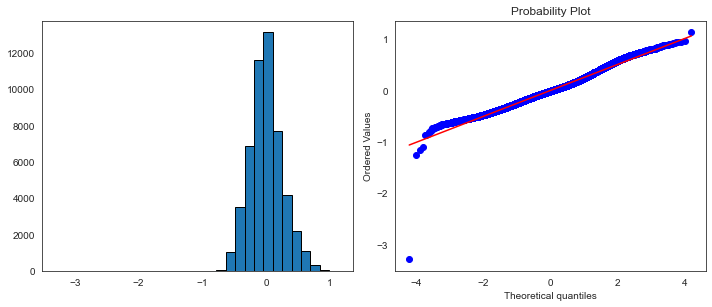

In [63]:
# data viz
fig = plt.figure(figsize = (10, 8))

# Plot fitted vs residual
#ax = fig.add_subplot(2, 2, 1)
#ax.plot(resid.residuals, linestyle = "None", marker = "o", markeredgecolor = "black")

# residual histogram
ax = fig.add_subplot(2, 2, 1)
ax.hist(resid_df.residuals, bins = 30, edgecolor = "black")

# residual Q-Q plot
ax = fig.add_subplot(2, 2, 2)
stats.probplot(resid_df.residuals, dist = "norm", plot = ax)
plt.tight_layout()
plt.show()